## Importing Libraries

In [211]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api   as sm
from pandas.io.json import json_normalize
from sklearn.model_selection   import train_test_split,GridSearchCV
from sklearn                   import metrics
from sklearn.ensemble          import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection   import cross_val_score
from sklearn.metrics           import accuracy_score,confusion_matrix

## Loading Data

In [2]:
path = 'C:/Users/Bhaskar/Desktop/Summit minds/customersdata.json'

In [3]:
# Load the first sheet of the JSON file into a data frame
df = pd.read_json(path, lines=True)
type(df)

pandas.core.frame.DataFrame

In [4]:
df.isnull().sum()

customer          0
fraudulent        0
orders            0
paymentMethods    0
transactions      0
dtype: int64

In [5]:
df['custid'] = df.index

In [6]:
df.head()

,customer,fraudulent,orders,paymentMethods,transactions,custid
0,"{'customerEmail': 'josephhoward@yahoo.com', 'c...",False,"[{'orderId': 'vjbdvd', 'orderAmount': 18, 'ord...","[{'paymentMethodId': 'wt07xm68b', 'paymentMeth...","[{'transactionId': 'a9lcj51r', 'orderId': 'vjb...",0
1,"{'customerEmail': 'evansjeffery@yahoo.com', 'c...",True,"[{'orderId': 'nlghpa', 'orderAmount': 45, 'ord...","[{'paymentMethodId': 'y3xp697jx', 'paymentMeth...","[{'transactionId': '5mi94sfw', 'orderId': 'nlg...",1
2,"{'customerEmail': 'andersonwilliam@yahoo.com',...",False,"[{'orderId': 'yk34y2', 'orderAmount': 33, 'ord...","[{'paymentMethodId': '8pneoi03z', 'paymentMeth...","[{'transactionId': 'q3lyvbza', 'orderId': 'yk3...",2
3,"{'customerEmail': 'rubenjuarez@yahoo.com', 'cu...",False,"[{'orderId': 'fbz9ep', 'orderAmount': 34, 'ord...","[{'paymentMethodId': 'pdxjdwui4', 'paymentMeth...","[{'transactionId': 'vx4cjc27', 'orderId': 'fbz...",3
4,"{'customerEmail': 'uchen@malone.com', 'custome...",True,"[{'orderId': '56h7iw', 'orderAmount': 71, 'ord...","[{'paymentMethodId': 'w1i1zq3rg', 'paymentMeth...","[{'transactionId': 'q8j3dgni', 'orderId': '56h...",4


- for customer

In [7]:
customer = pd.concat([df['custid'],json_normalize(df['customer']),df['fraudulent']],axis=1)
customer.head(3) 

,custid,customerBillingAddress,customerDevice,customerEmail,customerIPAddress,customerPhone,fraudulent
0,0,"5493 Jones Islands\nBrownside, CA 51896",yyeiaxpltf82440jnb3v,josephhoward@yahoo.com,8.129.104.40,400-108-5415,False
1,1,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True
2,2,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",4m7h5ipl1shyavt6vv2r,andersonwilliam@yahoo.com,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,024.420.0375,False


 - for Orders 

In [8]:
orders=pd.DataFrame({"custid":[], "orderAmount":[], "orderId":[], "orderShippingAddress":[], "orderState":[]})
rowcont=df.shape[0]
i=0
while (i < df.shape[0]):
    x=pd.DataFrame({"custid":[df['custid'][i]]*len(df['orders'][i])})
    y=pd.DataFrame(df['orders'][i])
    orders = orders.append(pd.concat([x,y],axis=1))
    i = i+1
orders.head()

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,custid,orderAmount,orderId,orderShippingAddress,orderState
0,0.0,18.0,vjbdvd,"5493 Jones Islands\nBrownside, CA 51896",pending
1,0.0,26.0,yp6x27,"5493 Jones Islands\nBrownside, CA 51896",fulfilled
0,1.0,45.0,nlghpa,"898 Henry Ports\nNew Keithview, CA 95893-2497",fulfilled
1,1.0,23.0,uw0eeb,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,fulfilled
2,1.0,43.0,bn44oh,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",fulfilled


- for paymentmethods

In [9]:
payment = pd.DataFrame({'paymentMethodId':[],'paymentMethodRegistrationFailure':[],'paymentMethodType':[],'paymentMethodProvider':[],'paymentMethodIssuer':[]})
rowcont=df.shape[0]
i=0
while (i < df.shape[0]):
    x=pd.DataFrame({"custid":[df['custid'][i]]*len(df['paymentMethods'][i])})
    y=pd.DataFrame(df['paymentMethods'][i])
    payment = payment.append(pd.concat([x,y],axis=1))
    i = i+1
payment.head()

,custid,paymentMethodId,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType
0,0.0,wt07xm68b,Citizens First Banks,JCB 16 digit,1.0,card
0,1.0,y3xp697jx,Solace Banks,VISA 16 digit,1.0,bitcoin
1,1.0,6krszxc05,Vertex Bancorp,VISA 16 digit,0.0,card
2,1.0,5z1szj2he,His Majesty Bank Corp.,Diners Club / Carte Blanche,0.0,card
3,1.0,m52tx8e1s,Vertex Bancorp,Mastercard,0.0,card


- for transactions

In [10]:
transaction = pd.DataFrame({'transactionId':[],'orderId':[],'paymentMethodId':[],'transactionAmount':[],'transactionFailed':[]})
rowcont=df.shape[0]
i=0
while (i < df.shape[0]):
    x=pd.DataFrame({"custid":[df['custid'][i]]*len(df['transactions'][i])})
    y=pd.DataFrame(df['transactions'][i])
    transaction = transaction.append(pd.concat([x,y],axis=1))
    i = i+1
transaction.head()

,custid,orderId,paymentMethodId,transactionAmount,transactionFailed,transactionId
0,0.0,vjbdvd,wt07xm68b,18.0,0.0,a9lcj51r
1,0.0,yp6x27,wt07xm68b,26.0,0.0,y4wcv03i
0,1.0,nlghpa,41ug157xz,45.0,0.0,5mi94sfw
1,1.0,uw0eeb,41ug157xz,23.0,0.0,br8ba1nu
2,1.0,bn44oh,y3xp697jx,43.0,1.0,a33145ss


In [11]:
payment.shape

(342, 6)

In [12]:
temp1 = pd.merge(transaction, payment, how='inner')

In [13]:
temp2 = pd.merge(temp1,orders, how='inner')

In [14]:
temp3 = pd.merge(temp2,customer, how='inner')

In [15]:
df1 = temp3

In [16]:
df1.columns

Index(['custid', 'orderId', 'paymentMethodId', 'transactionAmount',
       'transactionFailed', 'transactionId', 'paymentMethodIssuer',
       'paymentMethodProvider', 'paymentMethodRegistrationFailure',
       'paymentMethodType', 'orderAmount', 'orderShippingAddress',
       'orderState', 'customerBillingAddress', 'customerDevice',
       'customerEmail', 'customerIPAddress', 'customerPhone', 'fraudulent'],
      dtype='object')

In [17]:
df1['transactionFailed'].value_counts()

0.0    455
1.0    168
Name: transactionFailed, dtype: int64

In [18]:
df1['paymentMethodIssuer'].value_counts() 

Her Majesty Trust           66
His Majesty Bank Corp.      65
Vertex Bancorp              63
Fountain Financial Inc.     60
Bulwark Trust Corp.         59
Rose Bancshares             59
Bastion Banks               58
Citizens First Banks        55
Grand Credit Corporation    55
Solace Banks                41
B                           10
c                            7
e                            7
r                            6
a                            4
x                            4
o                            2
n                            1
p                            1
Name: paymentMethodIssuer, dtype: int64

In [19]:
df1['paymentMethodIssuer'] = df1['paymentMethodIssuer'].replace(to_replace =['B','e','c','r','x','a','o','p','n'], value ='others')

In [20]:
df1['paymentMethodIssuer'].value_counts()

Her Majesty Trust           66
His Majesty Bank Corp.      65
Vertex Bancorp              63
Fountain Financial Inc.     60
Rose Bancshares             59
Bulwark Trust Corp.         59
Bastion Banks               58
Grand Credit Corporation    55
Citizens First Banks        55
others                      42
Solace Banks                41
Name: paymentMethodIssuer, dtype: int64

In [21]:
df1['paymentMethodProvider'].value_counts()

JCB 16 digit                   118
VISA 16 digit                   96
Maestro                         69
Voyager                         61
Diners Club / Carte Blanche     58
VISA 13 digit                   58
American Express                45
JCB 15 digit                    45
Discover                        41
Mastercard                      32
Name: paymentMethodProvider, dtype: int64

In [22]:
df1['paymentMethodRegistrationFailure'].value_counts()

0.0    541
1.0     82
Name: paymentMethodRegistrationFailure, dtype: int64

In [23]:
df1['paymentMethodType'].value_counts()

card         479
apple pay     49
paypal        48
bitcoin       47
Name: paymentMethodType, dtype: int64

In [24]:
df1['paymentMethodType'].value_counts()

card         479
apple pay     49
paypal        48
bitcoin       47
Name: paymentMethodType, dtype: int64

In [25]:
df1['orderState'].value_counts()

fulfilled    516
failed        63
pending       44
Name: orderState, dtype: int64

In [26]:
df1['customerDevice'].value_counts()
pass
#drop it

In [28]:
df1['Email_type']=pd.DataFrame(df1['customerEmail'].str.split('@',expand=True))[1]
pd.DataFrame(df1['Email_type'].value_counts()) 

,Email_type
gmail.com,121
yahoo.com,118
hotmail.com,88
wright.com,19
turner-fleming.com,11
jedyz63t,10
levine-harmon.biz,8
mullins.biz,8
jackson-sanders.com,8
conner.com,8


In [29]:
df1['Email_type'].replace(['mullins.biz', 'jackson-sanders.com', 'levine-harmon.biz', 'conner.com',
       'tucker-brown.com', 'brown.com', 'pena.org', 'malone.com',
       'randall-pacheco.biz', 'mitchell-hancock.com', 'bell.com', '1jcfcxs7',
       'jones.com', 'hughes.biz', 'mckinney.com', 'wallace-johnson.com',
       'day.info', 'conrad.net', 'jones-lloyd.org', 'stephens-ortiz.com',
       'harris.com', 'singh.org', 'clark.biz', 'roman.org', 'rogers.com',
       'sutton.info', 'patrick-decker.com', 'mcgee.com', 'young.com',
       'reid.com', 'rodriguez.com', 'henderson.biz', 'arnold.com',
       'wright-boyd.org', 'chavez.com', 'hayes-wilson.biz', 'martin.com',
       'wolfe-brown.com', 'huffman.org', 'clark.com', 'russo.net',
       'brewer-jones.com', 'gray.biz', 'lopez-gomez.biz', 'gibson.com',
       'u6n7x', 'johnson-quinn.com', 'mosley.info', 'saunders-rhodes.com',
       'rasmussen-alvarado.com', 'lewis-haas.com', 'stafford.org',
       'hanson-key.org', 'nelson.net', 'gutierrez.net', 'knight.info',
       'stokes.com', 'randolph.com', 'lewis-baird.com', 'dunn.com', 'lamb.com',
       'cruz.info'], 'others', True)

In [35]:
counts = df1['Email_type'].value_counts()

In [33]:
 # x = counts[counts < 10].index

Index([], dtype='object')

In [32]:
df1['Email_type'].value_counts()

others                256
gmail.com             121
yahoo.com             118
hotmail.com            88
wright.com             19
turner-fleming.com     11
jedyz63t               10
Name: Email_type, dtype: int64

In [36]:
pd.crosstab(df1['Email_type'],df1['fraudulent'])

fraudulent,False,True
Email_type,,
gmail.com,57,64
hotmail.com,59,29
jedyz63t,0,10
others,149,107
turner-fleming.com,0,11
wright.com,6,13
yahoo.com,95,23


In [41]:
#df1['Email_add_type']=pd.DataFrame(df1['Email_type'].str.split('.',expand=True))[1]
#df1['Email_add_type'].value_counts()

In [42]:
#pd.crosstab(df1['Email_add_type'],df1['fraudulent'])

In [54]:
import ipaddress as ip
i=0
while i < len(df1['customerIPAddress']):
    x = ip.ip_address(df1['customerIPAddress'][i])
    i=i+1
x

IPv4Address('132.132.95.33')

In [55]:
df1['customerIPAddress']

0                                 8.129.104.40
1                                 8.129.104.40
2                              219.173.211.202
3                              219.173.211.202
4                              219.173.211.202
5      67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0
6      67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0
7      67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0
8      67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0
9      67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0
10     95de:8565:5a66:792c:26e0:6cfb:7d87:11af
11     95de:8565:5a66:792c:26e0:6cfb:7d87:11af
12     95de:8565:5a66:792c:26e0:6cfb:7d87:11af
13                              196.89.235.192
14                              196.89.235.192
15                              196.89.235.192
16                              196.89.235.192
17                              196.89.235.192
18                              196.89.235.192
19                              196.89.235.192
20                              43.166.163.164
21           

In [44]:
x = df1['customerBillingAddress']==df1['orderShippingAddress']
pd.crosstab(x,df1['fraudulent'])

fraudulent,False,True
row_0,,
False,104,100
True,262,157


In [108]:
df1.head()

,transactionAmount,transactionFailed,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType,orderAmount,orderState,customerEmail,customerIPAddress,fraudulent,Email_type
0,18.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,18.0,pending,josephhoward@yahoo.com,8.129.104.40,False,yahoo.com
1,26.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,26.0,fulfilled,josephhoward@yahoo.com,8.129.104.40,False,yahoo.com
2,45.0,0.0,Bastion Banks,American Express,0.0,bitcoin,45.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,True,yahoo.com
3,23.0,0.0,Bastion Banks,American Express,0.0,bitcoin,23.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,True,yahoo.com
4,43.0,1.0,Solace Banks,VISA 16 digit,1.0,bitcoin,43.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,True,yahoo.com


In [117]:
df1.shape[0]

623

In [127]:
df1['ip_multicast']     = False
df1['ip_private']       = False
df1['ip_unspecified']   = False
df1['ip_link_local']    = False
df1['ip_reserved']      = False
df1['ip_loopback']      = False
for k in range(df1.shape[0]):
    df1['ip_multicast'][k] = ip.ip_address(df1['customerIPAddress'][k]).is_multicast
    df1['ip_private'][k] = ip.ip_address(df1['customerIPAddress'][k]).is_private
    df1['ip_unspecified'][k] = ip.ip_address(df1['customerIPAddress'][k]).is_unspecified
    df1['ip_link_local'][k] = ip.ip_address(df1['customerIPAddress'][k]).is_link_local
    df1['ip_reserved'][k] = ip.ip_address(df1['customerIPAddress'][k]).is_reserved
    df1['ip_loopback'][k] =  ip.ip_address(df1['customerIPAddress'][k]).is_loopback

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\lib\site-packages\ipykernel_launch

In [155]:
version = [] 
i=0
while i < len(df1['customerIPAddress']):
    version.append(ip.ip_address(df1['customerIPAddress'][i]).version)
    i=i+1
version   

[4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 4,
 4,
 4,
 4,
 6,
 4,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 4,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,


In [157]:
df = pd.DataFrame(version,columns=['version_4'])

In [162]:
df1 = pd.concat([df1,df],axis=1)

In [164]:
df1.head()

,transactionAmount,transactionFailed,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType,orderAmount,orderState,customerEmail,customerIPAddress,...,Email_type,ip_multicast,ip_private,ip_unspecified,ip_link_local,ip_reserved,ip_loopback,ip_site_local,ip_version_4,version_4
0,18.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,18.0,pending,josephhoward@yahoo.com,8.129.104.40,...,yahoo.com,False,False,False,False,False,False,False,True,4
1,26.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,26.0,fulfilled,josephhoward@yahoo.com,8.129.104.40,...,yahoo.com,False,False,False,False,False,False,False,True,4
2,45.0,0.0,Bastion Banks,American Express,0.0,bitcoin,45.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,...,yahoo.com,False,False,False,False,False,False,False,True,4
3,23.0,0.0,Bastion Banks,American Express,0.0,bitcoin,23.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,...,yahoo.com,False,False,False,False,False,False,False,True,4
4,43.0,1.0,Solace Banks,VISA 16 digit,1.0,bitcoin,43.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,...,yahoo.com,False,False,False,False,False,False,False,True,4


In [181]:
df1['version_4'] = np.where(df1['version_4'] == 4, 1, 0)

In [182]:
df1['version_4'] 

0      1
1      1
2      1
3      1
4      1
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     1
14     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
28     1
29     0
      ..
593    0
594    0
595    1
596    1
597    1
598    1
599    1
600    1
601    1
602    1
603    1
604    0
605    0
606    0
607    0
608    1
609    1
610    1
611    1
612    1
613    1
614    1
615    1
616    1
617    1
618    1
619    1
620    1
621    1
622    1
Name: version_4, Length: 623, dtype: int32

In [183]:
df1.head()

,transactionAmount,transactionFailed,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType,orderAmount,orderState,customerEmail,customerIPAddress,...,Email_type,ip_multicast,ip_private,ip_unspecified,ip_link_local,ip_reserved,ip_loopback,ip_site_local,ip_version_4,version_4
0,18.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,18.0,pending,josephhoward@yahoo.com,8.129.104.40,...,yahoo.com,False,False,False,False,False,False,False,True,1
1,26.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,26.0,fulfilled,josephhoward@yahoo.com,8.129.104.40,...,yahoo.com,False,False,False,False,False,False,False,True,1
2,45.0,0.0,Bastion Banks,American Express,0.0,bitcoin,45.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,...,yahoo.com,False,False,False,False,False,False,False,True,1
3,23.0,0.0,Bastion Banks,American Express,0.0,bitcoin,23.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,...,yahoo.com,False,False,False,False,False,False,False,True,1
4,43.0,1.0,Solace Banks,VISA 16 digit,1.0,bitcoin,43.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,...,yahoo.com,False,False,False,False,False,False,False,True,1


In [191]:
# to_drop : ip_version_4, ip_site_local, ip_loopback, ip_link_local, ip_unspecified  
df1.drop(['ip_version_4', 'ip_site_local', 'ip_loopback', 'ip_link_local', 'ip_unspecified'],axis=1,inplace = True)

In [192]:
df1.head()

,transactionAmount,transactionFailed,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType,orderAmount,orderState,customerEmail,customerIPAddress,fraudulent,Email_type,ip_multicast,ip_private,ip_reserved,version_4
0,18.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,18.0,pending,josephhoward@yahoo.com,8.129.104.40,False,yahoo.com,False,False,False,1
1,26.0,0.0,Citizens First Banks,JCB 16 digit,1.0,card,26.0,fulfilled,josephhoward@yahoo.com,8.129.104.40,False,yahoo.com,False,False,False,1
2,45.0,0.0,Bastion Banks,American Express,0.0,bitcoin,45.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,True,yahoo.com,False,False,False,1
3,23.0,0.0,Bastion Banks,American Express,0.0,bitcoin,23.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,True,yahoo.com,False,False,False,1
4,43.0,1.0,Solace Banks,VISA 16 digit,1.0,bitcoin,43.0,fulfilled,evansjeffery@yahoo.com,219.173.211.202,True,yahoo.com,False,False,False,1


In [47]:
df1[['customerIPAddress','fraudulent']]

,customerIPAddress,fraudulent
0,8.129.104.40,False
1,8.129.104.40,False
2,219.173.211.202,True
3,219.173.211.202,True
4,219.173.211.202,True
5,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,False
6,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,False
7,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,False
8,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,False
9,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,False


In [48]:
df1[['custid','orderState']].drop_duplicates()

,custid,orderState
0,0.0,pending
1,0.0,fulfilled
2,1.0,fulfilled
5,2.0,failed
6,2.0,fulfilled
10,3.0,fulfilled
13,4.0,fulfilled
15,4.0,failed
20,5.0,pending
21,6.0,fulfilled


In [49]:
df1[['custid','orderShippingAddress']].drop_duplicates()

,custid,orderShippingAddress
0,0.0,"5493 Jones Islands\nBrownside, CA 51896"
2,1.0,"898 Henry Ports\nNew Keithview, CA 95893-2497"
3,1.0,356 Elizabeth Inlet Suite 120\nPort Joshuabury...
4,1.0,"5093 Bryan Forks\nJoshuaton, FM 01565-9801"
5,2.0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250"
8,2.0,"22396 Victor Lights\nCarsonstad, MO 93914"
10,3.0,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM..."
12,3.0,"428 Ricardo Mountain\nPort Lorihaven, UT 07665..."
13,4.0,"148 Russell Lodge Apt. 445\nPort Jenniferside,..."
16,4.0,"620 Alexander Views\nMichaelstad, AK 94959-7484"


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.subplot(2,4,1)
bplot = sns.boxplot(y='orderAmount', x='fraudulent', data=df1)

In [51]:
pd.crosstab(df1['transactionFailed'],df1['fraudulent'])

fraudulent,False,True
transactionFailed,,
0.0,258,197
1.0,108,60


In [53]:
df1['customerPhone'].value_counts()

1-321-386-6855x0101     15
1-804-264-1481x08539    13
1-414-937-7421x73705    11
000-734-4774            10
(508)223-3834           10
463-609-3475            10
962.300.2250             8
726-715-7429x06218       8
1-020-923-6697x8718      8
1-019-956-8013           8
266-228-3021x90360       8
05514762453              7
1-836-334-7673           7
04712252182              7
830-346-6543x518         7
599-142-6783             7
255-915-9059x3369        7
1-023-275-4692           7
952-580-9304x38838       7
1-114-728-2835x715       7
(089)703-7360x8848       7
1-981-877-0870           7
515.708.2280x105         6
04061905118              6
716-379-6345             6
+45(0)7468859801         6
629.489.3980             6
06238721842              6
(922)411-5121x98410      6
1-991-286-0655x973       6
                        ..
400-108-5415             2
479.228.3536             2
1-910-678-8300           2
986-625-5606             2
(099)775-4222            2
(986)656-8692x32356      2
0

In [56]:
data = df1

In [57]:
data.head()

,custid,orderId,paymentMethodId,transactionAmount,transactionFailed,transactionId,paymentMethodIssuer,paymentMethodProvider,paymentMethodRegistrationFailure,paymentMethodType,...,orderShippingAddress,orderState,customerBillingAddress,customerDevice,customerEmail,customerIPAddress,customerPhone,fraudulent,Email_type,Email_add_type
0,0.0,vjbdvd,wt07xm68b,18.0,0.0,a9lcj51r,Citizens First Banks,JCB 16 digit,1.0,card,...,"5493 Jones Islands\nBrownside, CA 51896",pending,"5493 Jones Islands\nBrownside, CA 51896",yyeiaxpltf82440jnb3v,josephhoward@yahoo.com,8.129.104.40,400-108-5415,False,yahoo.com,com
1,0.0,yp6x27,wt07xm68b,26.0,0.0,y4wcv03i,Citizens First Banks,JCB 16 digit,1.0,card,...,"5493 Jones Islands\nBrownside, CA 51896",fulfilled,"5493 Jones Islands\nBrownside, CA 51896",yyeiaxpltf82440jnb3v,josephhoward@yahoo.com,8.129.104.40,400-108-5415,False,yahoo.com,com
2,1.0,nlghpa,41ug157xz,45.0,0.0,5mi94sfw,Bastion Banks,American Express,0.0,bitcoin,...,"898 Henry Ports\nNew Keithview, CA 95893-2497",fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True,yahoo.com,com
3,1.0,uw0eeb,41ug157xz,23.0,0.0,br8ba1nu,Bastion Banks,American Express,0.0,bitcoin,...,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True,yahoo.com,com
4,1.0,bn44oh,y3xp697jx,43.0,1.0,a33145ss,Solace Banks,VISA 16 digit,1.0,bitcoin,...,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,r0jpm7xaeqqa3kr6mzum,evansjeffery@yahoo.com,219.173.211.202,1-788-091-7546,True,yahoo.com,com


In [62]:
data.columns

Index(['transactionAmount', 'transactionFailed', 'paymentMethodIssuer',
       'paymentMethodProvider', 'paymentMethodRegistrationFailure',
       'paymentMethodType', 'orderAmount', 'orderState', 'customerEmail',
       'customerIPAddress', 'fraudulent', 'Email_type'],
      dtype='object')

In [67]:
data['Email_type'].value_counts()

others                256
gmail.com             121
yahoo.com             118
hotmail.com            88
wright.com             19
turner-fleming.com     11
jedyz63t               10
Name: Email_type, dtype: int64

In [61]:
data.drop(['custid','orderId','paymentMethodId','transactionId','orderShippingAddress','customerBillingAddress','customerDevice','customerPhone'],axis=1,inplace = True)

In [194]:
x = pd.get_dummies(data[['paymentMethodIssuer','paymentMethodProvider','paymentMethodType','orderState','Email_type']])

In [195]:
x.head()

,paymentMethodIssuer_Bastion Banks,paymentMethodIssuer_Bulwark Trust Corp.,paymentMethodIssuer_Citizens First Banks,paymentMethodIssuer_Fountain Financial Inc.,paymentMethodIssuer_Grand Credit Corporation,paymentMethodIssuer_Her Majesty Trust,paymentMethodIssuer_His Majesty Bank Corp.,paymentMethodIssuer_Rose Bancshares,paymentMethodIssuer_Solace Banks,paymentMethodIssuer_Vertex Bancorp,...,orderState_failed,orderState_fulfilled,orderState_pending,Email_type_gmail.com,Email_type_hotmail.com,Email_type_jedyz63t,Email_type_others,Email_type_turner-fleming.com,Email_type_wright.com,Email_type_yahoo.com
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
# to convert into int ip_multicast,ip_private,ip_reserved

In [236]:
df1.head()

,transactionAmount,transactionFailed,paymentMethodRegistrationFailure,fraudulent,ip_multicast,ip_private,ip_reserved,version_4,paymentMethodIssuer_Bastion Banks,paymentMethodIssuer_Bulwark Trust Corp.,...,paymentMethodType_bitcoin,paymentMethodType_paypal,orderState_failed,orderState_pending,Email_type_gmail.com,Email_type_hotmail.com,Email_type_jedyz63t,Email_type_turner-fleming.com,Email_type_wright.com,Email_type_yahoo.com
0,18.0,0.0,1.0,False,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,26.0,0.0,1.0,False,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45.0,0.0,0.0,True,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
3,23.0,0.0,0.0,True,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,43.0,1.0,1.0,True,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [235]:
df1.ip_multicast = df1.ip_multicast.astype(int)
df1.ip_private = df1.ip_private.astype(int)
df1.ip_reserved = df1.ip_reserved.astype(int)

In [198]:
# to drop dummies
# paymentMethodIssuer_others,paymentMethodProvider_VISA 16 digit,paymentMethodType_card ,orderState_fulfilled,Email_type_others  
x.drop(['paymentMethodIssuer_others','paymentMethodProvider_VISA 16 digit','paymentMethodType_card' ,'orderState_fulfilled','Email_type_others'],axis=1,inplace=True)

In [209]:
df1.drop(['paymentMethodIssuer','paymentMethodProvider','paymentMethodType','orderState','Email_type','orderAmount','customerIPAddress'],axis=1,inplace=True)

In [220]:
del df1['customerEmail']

In [202]:
df1.shape

(623, 10)

In [204]:
df1 = pd.concat([df1,x],axis=1)

In [205]:
df1.shape

(623, 40)

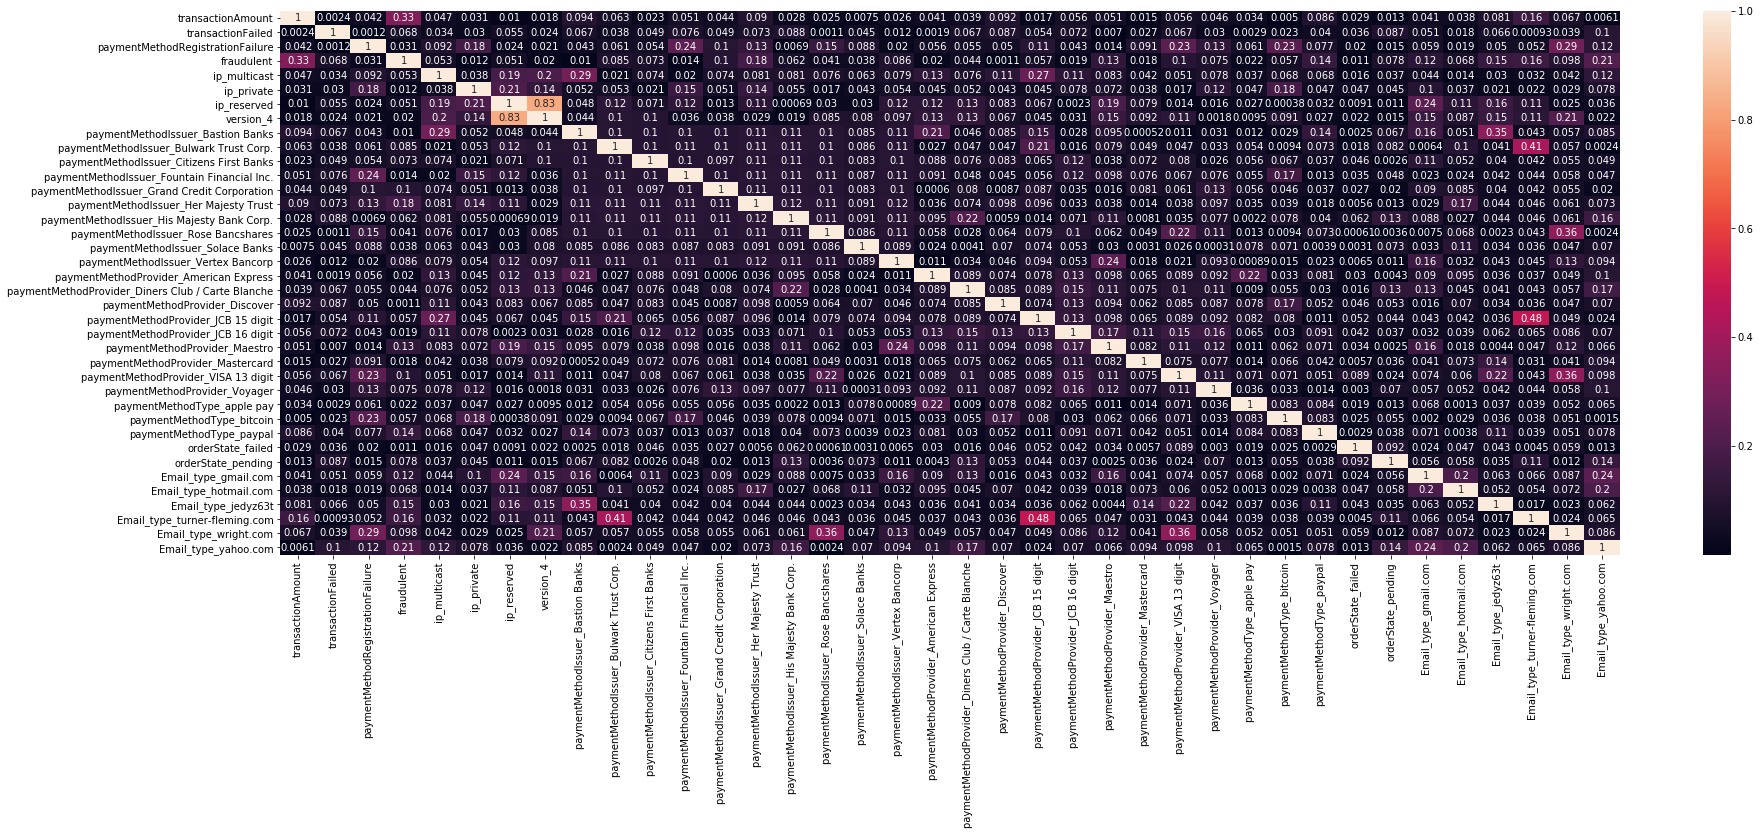

In [210]:
plt.figure(figsize = (30,10)) 
sns.heatmap(df1.corr().abs(), annot = True)
plt.show()

## Model Building

In [237]:
X_train, X_test, Y_train, Y_test = train_test_split(df1.drop('fraudulent', axis=1), df1['fraudulent'],test_size=0.15, random_state=3)

In [238]:
X_train.shape

(529, 37)

In [240]:
df1.head()

,transactionAmount,transactionFailed,paymentMethodRegistrationFailure,fraudulent,ip_multicast,ip_private,ip_reserved,version_4,paymentMethodIssuer_Bastion Banks,paymentMethodIssuer_Bulwark Trust Corp.,...,paymentMethodType_bitcoin,paymentMethodType_paypal,orderState_failed,orderState_pending,Email_type_gmail.com,Email_type_hotmail.com,Email_type_jedyz63t,Email_type_turner-fleming.com,Email_type_wright.com,Email_type_yahoo.com
0,18.0,0.0,1.0,False,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,26.0,0.0,1.0,False,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45.0,0.0,0.0,True,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
3,23.0,0.0,0.0,True,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,43.0,1.0,1.0,True,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1


In [241]:
X_test.shape

(94, 37)

### Random Forest

In [245]:
rf = RandomForestClassifier(n_estimators=100,random_state=100,n_jobs=5,max_depth=25).fit(X_train, Y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

In [246]:
rf.feature_importances_

array([0.29273286, 0.019866  , 0.02402779, 0.01414429, 0.00605925,
       0.02950195, 0.0274651 , 0.01307201, 0.01765326, 0.01760551,
       0.02245467, 0.02260491, 0.0308777 , 0.01669273, 0.02065055,
       0.01708409, 0.02603483, 0.01678306, 0.01768012, 0.01936323,
       0.01982989, 0.02568847, 0.016147  , 0.01546538, 0.01684845,
       0.02062443, 0.01708346, 0.01725783, 0.02031698, 0.01551036,
       0.01043123, 0.0343115 , 0.02210806, 0.01774376, 0.00910366,
       0.00972406, 0.0394516 ])

In [247]:
cols  = list(zip(list(X_train.columns),list(rf.feature_importances_)))
fi = pd.DataFrame(cols, columns = ['feature','importance'])
fi = fi.sort_values(by = 'importance',axis=0,inplace=False,ascending=False,kind='quicksort')

In [248]:
fi

,feature,importance
0,transactionAmount,0.292733
36,Email_type_yahoo.com,0.039452
31,Email_type_gmail.com,0.034312
12,paymentMethodIssuer_Her Majesty Trust,0.030878
5,ip_reserved,0.029502
6,version_4,0.027465
16,paymentMethodIssuer_Vertex Bancorp,0.026035
21,paymentMethodProvider_JCB 16 digit,0.025688
2,paymentMethodRegistrationFailure,0.024028
11,paymentMethodIssuer_Grand Credit Corporation,0.022605


In [249]:
predictions = rf.predict(X_test)
predictions

array([False, False,  True, False,  True, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True, False,  True, False, False, False,  True,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False,  True, False, False,  True,
       False,  True, False, False, False, False, False,  True, False,
        True, False,  True, False,  True, False,  True,  True, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
        True,  True, False,  True])

In [250]:
rf.score(X_train,Y_train)

1.0

In [251]:
rf.score(X_test,Y_test)

0.9042553191489362

In [252]:
confusion_mat = metrics.confusion_matrix(Y_test, predictions)
confusion_df = pd.DataFrame(confusion_mat, index=['Actual 0','Actual 1'], columns=['Predicted 0','Predicted 1'])
confusion_df

,Predicted 0,Predicted 1
Actual 0,58,2
Actual 1,7,27


In [253]:
cols = list(fi['feature'])

In [254]:
rf = RandomForestClassifier(n_estimators=100,random_state=100,n_jobs=5,max_depth=25).fit(X_train[cols], Y_train)
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
                       oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

In [255]:
predictions = rf.predict(X_test)
predictions

array([False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
        True,  True, False,  True,  True, False,  True, False, False,
       False,  True, False, False,  True, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True,  True, False,  True])

In [256]:
rf.score(X_train,Y_train)

0.6786389413988658

In [257]:
rf.score(X_test,Y_test)

0.6808510638297872

In [258]:
confusion_mat = metrics.confusion_matrix(Y_test, predictions)
confusion_df = pd.DataFrame(confusion_mat, index=['Actual 0','Actual 1'], columns=['Predicted 0','Predicted 1'])
confusion_df

,Predicted 0,Predicted 1
Actual 0,50,10
Actual 1,20,14
